# Gameday Model for SPX

In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import yfinance as yf
import json
import requests
from bs4 import BeautifulSoup
from typing import List
import xgboost as xgb
from tqdm import tqdm
from sklearn import linear_model, ensemble
import joblib

# Helper Functions

In [2]:
f = open('settings.json')
j = json.load(f)
API_KEY_FRED = j['API_KEY_FRED']

def get_data():
    def parse_release_dates(release_id: str) -> List[str]:
        release_dates_url = f'https://api.stlouisfed.org/fred/release/dates?release_id={release_id}&realtime_start=2015-01-01&include_release_dates_with_no_data=true&api_key={API_KEY_FRED}'
        r = requests.get(release_dates_url)
        text = r.text
        soup = BeautifulSoup(text, 'xml')
        dates = []
        for release_date_tag in soup.find_all('release_date', {'release_id': release_id}):
            dates.append(release_date_tag.text)
        return dates

    def parse_release_dates_obs(series_id: str) -> List[str]:
        obs_url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&realtime_start=2015-01-01&include_release_dates_with_no_data=true&api_key={API_KEY_FRED}'
        r = requests.get(obs_url)
        text = r.text
        soup = BeautifulSoup(text, 'xml')
        observations  = []
        for observation_tag in soup.find_all('observation'):
            date = observation_tag.get('date')
            value = observation_tag.get('value')
            observations.append((date, value))
        return observations

    econ_dfs = {}

    econ_tickers = [
        'WALCL',
        'NFCI',
        'WRESBAL'
    ]

    for et in tqdm(econ_tickers, desc='getting econ tickers'):
        # p = parse_release_dates_obs(et)
        # df = pd.DataFrame(columns = ['ds',et], data = p)
        df = pdr.get_data_fred(et)
        df.index = df.index.rename('ds')
        # df.index = pd.to_datetime(df.index.rename('ds')).dt.tz_localize(None)
        # df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
        econ_dfs[et] = df

    # walcl = pd.DataFrame(columns = ['ds','WALCL'], data = p)
    # walcl['ds'] = pd.to_datetime(walcl['ds']).dt.tz_localize(None)

    # nfci = pd.DataFrame(columns = ['ds','NFCI'], data = p2)
    # nfci['ds'] = pd.to_datetime(nfci['ds']).dt.tz_localize(None)

    release_ids = [
        "10", # "Consumer Price Index"
        "46", # "Producer Price Index"
        "50", # "Employment Situation"
        "53", # "Gross Domestic Product"
        "103", # "Discount Rate Meeting Minutes"
        "180", # "Unemployment Insurance Weekly Claims Report"
        "194", # "ADP National Employment Report"
        "323" # "Trimmed Mean PCE Inflation Rate"
    ]

    release_names = [
        "CPI",
        "PPI",
        "NFP",
        "GDP",
        "FOMC",
        "UNEMP",
        "ADP",
        "PCE"
    ]

    releases = {}

    for rid, n in tqdm(zip(release_ids, release_names), total = len(release_ids), desc='Getting release dates'):
        releases[rid] = {}
        releases[rid]['dates'] = parse_release_dates(rid)
        releases[rid]['name'] = n 

    # Create a DF that has all dates with the name of the col as 1
    # Once merged on the main dataframe, days with econ events will be 1 or None. Fill NA with 0
    # This column serves as the true/false indicator of whether there was economic data released that day.
    for rid in tqdm(release_ids, desc='Making indicators'):
        releases[rid]['df'] = pd.DataFrame(
            index=releases[rid]['dates'],
            data={
            releases[rid]['name']: 1
            })
        releases[rid]['df'].index = pd.DatetimeIndex(releases[rid]['df'].index)
        # releases[rid]['df']['ds'] = pd.to_datetime(releases[rid]['df']['ds']).dt.tz_localize(None)
        # releases[rid]['df'] = releases[rid]['df'].set_index('ds')

    vix = yf.Ticker('^VIX')
    spx = yf.Ticker('^GSPC')

    prices_vix = vix.history(start='2018-07-01', interval='1d')
    prices_spx = spx.history(start='2018-07-01', interval='1d')

    prices_spx['index'] = [str(x).split()[0] for x in prices_spx.index]
    prices_spx['index'] = pd.to_datetime(prices_spx['index']).dt.date
    prices_spx.index = prices_spx['index']
    prices_spx = prices_spx.drop(columns='index')

    prices_vix['index'] = [str(x).split()[0] for x in prices_vix.index]
    prices_vix['index'] = pd.to_datetime(prices_vix['index']).dt.date
    prices_vix.index = prices_vix['index']
    prices_vix = prices_vix.drop(columns='index')

    data = prices_spx.merge(prices_vix[['Open','High','Low','Close']], left_index=True, right_index=True, suffixes=['','_VIX'])
    data.index = pd.DatetimeIndex(data.index)

    # Features
    data['PrevClose'] = data['Close'].shift(1)
    data['Perf5Day'] = data['Close'] > data['Close'].shift(5)
    data['Perf5Day_n1'] = data['Perf5Day'].shift(1)
    data['Perf5Day_n1'] = data['Perf5Day_n1'].astype(bool)
    data['GreenDay'] = (data['Close'] > data['PrevClose']) * 1
    data['RedDay'] = (data['Close'] <= data['PrevClose']) * 1

    data['VIX5Day'] = data['Close_VIX'] > data['Close_VIX'].shift(5)
    data['VIX5Day_n1'] = data['VIX5Day'].astype(bool)

    data['Range'] = data[['Open','High']].max(axis=1) - data[['Low','Open']].min(axis=1) # Current day range in points
    data['RangePct'] = data['Range'] / data['Close']
    data['VIXLevel'] = pd.qcut(data['Close_VIX'], 4)
    data['OHLC4_VIX'] = data[['Open_VIX','High_VIX','Low_VIX','Close_VIX']].mean(axis=1)
    data['OHLC4'] = data[['Open','High','Low','Close']].mean(axis=1)
    data['OHLC4_Trend'] = data['OHLC4'] > data['OHLC4'].shift(1)
    data['OHLC4_Trend_n1'] = data['OHLC4_Trend'].shift(1)
    data['OHLC4_Trend_n1'] = data['OHLC4_Trend_n1'].astype(float)
    data['OHLC4_Trend_n2'] = data['OHLC4_Trend'].shift(1)
    data['OHLC4_Trend_n2'] = data['OHLC4_Trend_n2'].astype(float)
    data['RangePct_n1'] = data['RangePct'].shift(1)
    data['RangePct_n2'] = data['RangePct'].shift(2)
    data['OHLC4_VIX_n1'] = data['OHLC4_VIX'].shift(1)
    data['OHLC4_VIX_n2'] = data['OHLC4_VIX'].shift(2)
    data['CurrentGap'] = (data['Open'] - data['PrevClose']) / data['PrevClose']
    data['CurrentGap'] = data['CurrentGap'].shift(-1)
    data['GapLevel'] = data['CurrentGap'].apply(lambda x: 1 if x < -0.0033 else 2 if x < -0.0015 else 3 if x < 0.0016 else 4)
    data['GapLevel'] = data['GapLevel'].astype(int)
    data['DayOfWeek'] = pd.to_datetime(data.index)
    data['DayOfWeek'] = data['DayOfWeek'].dt.day

    # Target -- the next day's low
    data['Target'] = (data['OHLC4'] / data['PrevClose']) - 1
    data['Target'] = data['Target'].shift(-1)
    # data['Target'] = data['RangePct'].shift(-1)

    # Target for clf -- whether tomorrow will close above or below today's close
    data['Target_clf'] = data['Close'] > data['PrevClose']
    data['Target_clf'] = data['Target_clf'].shift(-1)
    data['DayOfWeek'] = pd.to_datetime(data.index)
    data['Quarter'] = data['DayOfWeek'].dt.quarter
    data['DayOfWeek'] = data['DayOfWeek'].dt.weekday

    for rid in tqdm(release_ids, desc='Merging econ data'):
        # Get the name of the release
        n = releases[rid]['name']
        # Merge the corresponding DF of the release
        data = data.merge(releases[rid]['df'], how = 'left', left_index=True, right_index=True)
        # Create a column that shifts the value in the merged column up by 1
        data[f'{n}_shift'] = data[n].shift(-1)
        # Fill the rest with zeroes
        data[n] = data[n].fillna(0)
        data[f'{n}_shift'] = data[f'{n}_shift'].fillna(0)
        
    data['BigNewsDay'] = data[[x for x in data.columns if '_shift' in x]].max(axis=1)
    
    def cumul_sum(col):
        nums = []
        s = 0
        for x in col:
            if x == 1:
                s += 1
            elif x == 0:
                s = 0
            nums.append(s)
        return nums

    consec_green = cumul_sum(data['GreenDay'].values)
    consec_red = cumul_sum(data['RedDay'].values)

    data['DaysGreen'] = consec_green
    data['DaysRed'] = consec_red

    final_row = data.index[-2]
    
    df_final = data.loc[:final_row,
    [
        'BigNewsDay',
        'Quarter',
        'Perf5Day',
        'Perf5Day_n1',
        'DaysGreen',
        'DaysRed',
        # 'OHLC4_Trend',
        # 'OHLC4_Trend_n1',
        # 'OHLC4_Trend_n2',
        # 'VIX5Day',
        # 'VIX5Day_n1',
        'CurrentGap',
        'GapLevel',
        'RangePct',
        'RangePct_n1',
        'RangePct_n2',
        'OHLC4_VIX',
        'OHLC4_VIX_n1',
        'OHLC4_VIX_n2',
        'Target',
        'Target_clf'
        ]]
    df_final = df_final.dropna(subset=['Target','Target_clf','Perf5Day_n1'])
    return df_final

def train_model1(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    # model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state = 42)
    model = linear_model.LinearRegression()

    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1), desc='OHLC4 Model'):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict(X_test)
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    # model.save_model('model_lr.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

def train_model_seq(df, target_column_clf, target_column_regr, num_training_rows, num_periods):
    '''
    Instead of running everything in memory, try to save the outputs and load them later.
    '''
    # Create run the regression model to get its target
    res, model1 = train_model1(df.drop(columns=[target_column_clf]).dropna(), target_column_regr, num_training_rows, num_periods)
    joblib.dump(model1, 'model1.bin')

    # Merge the result df back on the df for feeding into the classifier
    for_merge = res[['Predicted']]
    for_merge.columns = ['RegrModelOut']
    for_merge['RegrModelOut'] = for_merge['RegrModelOut'] > 0
    df = df.merge(for_merge, left_index=True, right_index=True)
    df = df.drop(columns=[target_column_regr])
    df = df[[
        'CurrentGap','RegrModelOut',target_column_clf
        ]]
    
    df[target_column_clf] = df[target_column_clf].astype(bool)

    # Create an XGBRegressor model
    model2 = xgb.XGBClassifier(n_estimators=10, random_state = 42)
    # model = linear_model.LogisticRegression(max_iter=1500)

    
    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1), desc='CLF Model'):
        # Split the data into training and test sets
        X_train = df.drop(target_column_clf, axis=1).iloc[:i]
        y_train = df[target_column_clf].iloc[:i]
        X_test = df.drop(target_column_clf, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column_clf].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model2.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model2.predict_proba(X_test)[:,-1]
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    # Save locally
    joblib.dump(model2, 'model2.bin')
    df_results.to_csv('df_results.csv')

def predict_proba_seq():

    data = get_data()
    final_row = data.index[-2]
    # Get last row
    new_pred = data.loc[final_row, ['BigNewsDay',
        'Quarter',
        'Perf5Day',
        'Perf5Day_n1',    
        'DaysGreen',    
        'DaysRed',    
        # 'OHLC4_Trend',    
        # 'OHLC4_Trend_n1',    
        # 'OHLC4_Trend_n2',    
        # 'VIX5Day',
        # 'VIX5Day_n1',
        'CurrentGap',
        'GapLevel',
        'RangePct',
        'RangePct_n1',
        'RangePct_n2',
        'OHLC4_VIX',
        'OHLC4_VIX_n1',
        'OHLC4_VIX_n2']]

    new_pred = pd.DataFrame(new_pred).T

    new_pred['BigNewsDay'] = new_pred['BigNewsDay'].astype(float)
    new_pred['Quarter'] = new_pred['Quarter'].astype(int)
    new_pred['Perf5Day'] = new_pred['Perf5Day'].astype(bool)
    new_pred['Perf5Day_n1'] = new_pred['Perf5Day_n1'].astype(bool)
    new_pred['DaysGreen'] = new_pred['DaysGreen'].astype(float)
    new_pred['DaysRed'] = new_pred['DaysRed'].astype(float)
    # new_pred['OHLC4_Trend'] = new_pred['OHLC4_Trend'].astype(float)
    # new_pred['OHLC4_Trend_n1'] = new_pred['OHLC4_Trend_n1'].astype(float)
    # new_pred['OHLC4_Trend_n2'] = new_pred['OHLC4_Trend_n2'].astype(float)
    # new_pred['VIX5Day'] = new_pred['VIX5Day'].astype(bool)
    # new_pred['VIX5Day_n1'] = new_pred['VIX5Day_n1'].astype(bool)
    new_pred['CurrentGap'] = new_pred['CurrentGap'].astype(float)
    new_pred['GapLevel'] = new_pred['GapLevel'].astype(int)
    new_pred['RangePct'] = new_pred['RangePct'].astype(float)
    new_pred['RangePct_n1'] = new_pred['RangePct_n1'].astype(float)
    new_pred['RangePct_n2'] = new_pred['RangePct_n2'].astype(float)
    new_pred['OHLC4_VIX'] = new_pred['OHLC4_VIX'].astype(float)
    new_pred['OHLC4_VIX_n1'] = new_pred['OHLC4_VIX_n1'].astype(float)
    new_pred['OHLC4_VIX_n2'] = new_pred['OHLC4_VIX_n2'].astype(float)

    trained_reg_model = joblib.load('model1.bin')
    trained_clf_model = joblib.load('model2.bin')
    print(new_pred)
    regr_pred = trained_reg_model.predict(new_pred)
    regr_pred = regr_pred > 0
    new_df = new_pred.copy()
    new_df['RegrModelOut'] = regr_pred
    clf_pred_proba = trained_clf_model.predict_proba(new_df[['CurrentGap','RegrModelOut']])[:,-1]
    return clf_pred_proba

# Regression Model

In [3]:
df_final = get_data()
res, model01 = train_model1(df_final.drop(columns=['Target_clf']).dropna(), 'Target', 100, 1)

OHLC4 Model: 100%|██████████| 1164/1164 [00:03<00:00, 372.52it/s]


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=res['True'],
                   y_pred=res['Predicted'])

253.83898827431705

In [5]:
mean_absolute_error(y_true=res['True'],
                   y_pred=res['Predicted']) * 100

0.3617049544274253

<AxesSubplot:xlabel='index'>

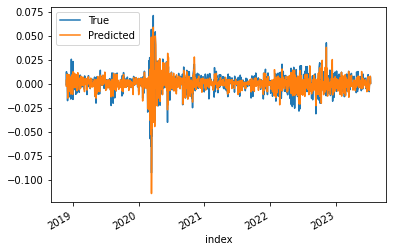

In [6]:
res.plot()

In [7]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 8))
# xgb.plot_importance(xgbr, importance_type='weight', ax=ax)

In [8]:
np.mean(df_final['CurrentGap'].abs()>0.0015)

0.684044233807267

# Sequential Model

In [9]:
train_model_seq(df_final.dropna(), 'Target_clf', 'Target', 100, 1)

OHLC4 Model: 100%|██████████| 1164/1164 [00:03<00:00, 364.93it/s]
C:\Users\WINSTON-ITX\AppData\Local\Temp\ipykernel_2044\161169059.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_merge['RegrModelOut'] = for_merge['RegrModelOut'] > 0
CLF Model: 100%|██████████| 1064/1064 [00:08<00:00, 121.67it/s]


In [10]:
res2 = pd.read_csv('df_results.csv',index_col=0)

In [11]:
res2.tail()

,True,Predicted
index,,
2023-07-07,True,0.364264
2023-07-10,True,0.667768
2023-07-11,True,0.810105
2023-07-12,True,0.912171
2023-07-13,False,0.471872


In [12]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, PrecisionRecallDisplay
print(roc_auc_score(res2['True'].astype(int), res2['Predicted'].values))
print(precision_score(res2['True'].astype(int), res2['Predicted'] > 0.5))
print(recall_score(res2['True'].astype(int), res2['Predicted'] > 0.5))
# print(roc_auc_score(res1['True'].astype(int), res1['Predicted'].values))

0.7376853714881884
0.6862416107382551
0.7213403880070547


In [13]:
res2.groupby(res2['Predicted'] <= 0.42).agg({'True':[np.mean,len,np.sum]})

True          
               mean  len  sum
Predicted                    
False      0.662757  682  452
True       0.301047  382  115

In [14]:
res2.groupby(pd.qcut(res2['Predicted'],5)).agg({'True':[np.mean,len,np.sum]})

True          
                     mean  len  sum
Predicted                          
(0.0481, 0.274]  0.244131  213   52
(0.274, 0.47]    0.399061  213   85
(0.47, 0.661]    0.523585  212  111
(0.661, 0.838]   0.685446  213  146
(0.838, 0.954]   0.812207  213  173

In [15]:
len(res2)

1064

In [16]:
res2.groupby(res2['Predicted'] > .75).agg({'True':[np.mean,len]})

True     
               mean  len
Predicted               
False      0.418256  734
True       0.787879  330

In [17]:
res2['Predicted']

index
2019-04-23    0.615764
2019-04-24    0.243159
2019-04-25    0.322760
2019-04-26    0.217133
2019-04-29    0.535138
                ...   
2023-07-07    0.364264
2023-07-10    0.667768
2023-07-11    0.810105
2023-07-12    0.912171
2023-07-13    0.471872
Name: Predicted, Length: 1064, dtype: float64

In [18]:
res2['True'].mean()

0.5328947368421053

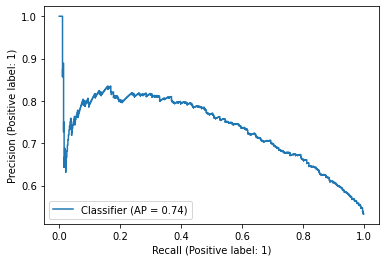

In [19]:
PrecisionRecallDisplay.from_predictions(res2['True'].astype(int), res2['Predicted'].values)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

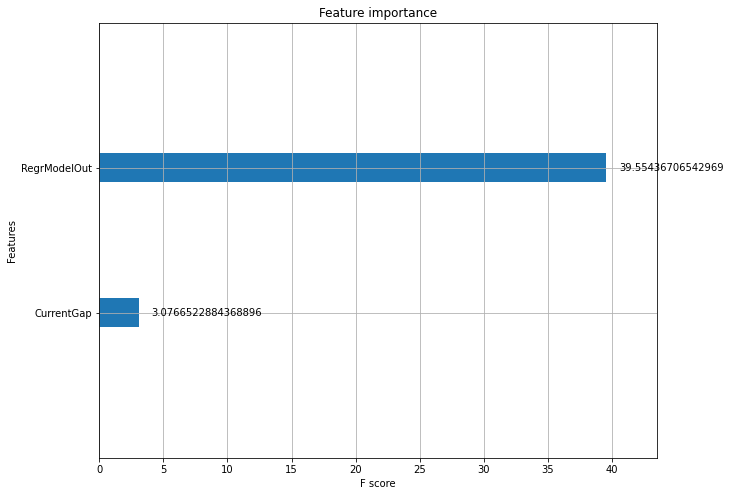

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
clf_model = joblib.load('model2.bin')
xgb.plot_importance(clf_model, importance_type='gain', ax=ax)

In [21]:
df_compare = df_final.drop(columns=['Target','Target_clf']).merge(res2, left_index=True, right_index=True)

# What do these false positives look like?
# false_pos = df_compare.loc[(df_compare['True'] == False) & (df_compare['Predicted'] > 0.5)]

# New Prediction

In [22]:
predict_proba_seq()

Merging econ data: 100%|██████████| 8/8 [00:00<00:00, 999.09it/s]

            BigNewsDay  Quarter  Perf5Day  Perf5Day_n1  DaysGreen  DaysRed  \
2023-07-12         1.0        3      True        False        3.0      0.0   

            CurrentGap  GapLevel  RangePct  RangePct_n1  RangePct_n2  \
2023-07-12    0.004324         4  0.005615     0.007925     0.005143   

            OHLC4_VIX  OHLC4_VIX_n1  OHLC4_VIX_n2  
2023-07-12    14.1725        14.935          15.6  


array([0.9261149], dtype=float32)

In [23]:
res2.groupby(res2['Predicted'] >= 0.59).agg({'True':[np.mean,len,np.sum]})

True          
               mean  len  sum
Predicted                    
False      0.362976  551  200
True       0.715400  513  367

In [24]:
# How do I say: when the model produces a probability of at least X, the likelihood of 
res2.groupby(pd.cut(res2['Predicted'],bins=[-np.inf,0.2,0.4,0.6,0.8,np.inf])).agg({'True':[np.mean,len,np.sum]})

True          
                 mean  len  sum
Predicted                      
(-inf, 0.2]  0.201754  114   23
(0.2, 0.4]   0.337398  246   83
(0.4, 0.6]   0.497585  207  103
(0.6, 0.8]   0.632035  231  146
(0.8, inf]   0.796992  266  212

In [25]:
def get_total_gt_pred(x):
    return len(res2.loc[(res2['Predicted'] >= x)])

def get_total_lte_pred(x):
    return len(res2.loc[(res2['Predicted'] <= x)])

def get_green_gt(x):
    return len(res2.loc[(res2['Predicted'] >= x) & (res2['True'] == True)])

def get_red_gt(x):
    return len(res2.loc[(res2['Predicted'] >= x) & (res2['True'] == False)])

def get_green_lte(x):
    return len(res2.loc[(res2['Predicted'] <= x) & (res2['True'] == True)])

def get_red_lte(x):
    return len(res2.loc[(res2['Predicted'] <= x) & (res2['True'] == False)])

In [26]:
res2['TotalGT'] = res2['Predicted'].apply(get_total_gt_pred)
res2['TotalGreenGT'] = res2['Predicted'].apply(get_green_gt)
res2['TotalRedGT'] = res2['Predicted'].apply(get_red_gt)

res2['TotalLTE'] = res2['Predicted'].apply(get_total_lte_pred)
res2['TotalGreenLTE'] = res2['Predicted'].apply(get_green_lte)
res2['TotalRedLTE'] = res2['Predicted'].apply(get_red_lte)

In [27]:
res2

,True,Predicted,TotalGT,TotalGreenGT,TotalRedGT,TotalLTE,TotalGreenLTE,TotalRedLTE
index,,,,,,,,
2019-04-23,False,0.615764,484,351,133,581,216,365
2019-04-24,False,0.243159,891,527,364,174,40,134
2019-04-25,True,0.322760,791,495,296,274,73,201
2019-04-26,True,0.217133,921,537,384,144,31,113
2019-04-29,True,0.535138,554,391,163,511,177,334
...,...,...,...,...,...,...,...,...
2023-07-07,True,0.364264,737,475,262,328,93,235
2023-07-10,True,0.667768,417,313,104,648,255,393
2023-07-11,True,0.810105,249,201,48,816,367,449


## Pre Market Prediction

In [28]:
# Get actual last row
exp_pred = data[['BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',    
    'DaysGreen',    
    'DaysRed',    
    # 'OHLC4_Trend',    
    # 'OHLC4_Trend_n1',    
    # 'OHLC4_Trend_n2',    
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'GapLevel',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2']].iloc[-1]

exp_pred = pd.DataFrame(exp_pred).T

exp_pred['BigNewsDay'] = exp_pred['BigNewsDay'].astype(float)
exp_pred['Quarter'] = exp_pred['Quarter'].astype(int)
exp_pred['Perf5Day'] = exp_pred['Perf5Day'].astype(bool)
exp_pred['Perf5Day_n1'] = exp_pred['Perf5Day_n1'].astype(bool)
exp_pred['DaysGreen'] = exp_pred['DaysGreen'].astype(float)
exp_pred['DaysRed'] = exp_pred['DaysRed'].astype(float)
# exp_pred['OHLC4_Trend'] = exp_pred['OHLC4_Trend'].astype(float)
# exp_pred['OHLC4_Trend_n1'] = exp_pred['OHLC4_Trend_n1'].astype(float)
# exp_pred['OHLC4_Trend_n2'] = exp_pred['OHLC4_Trend_n2'].astype(float)
# exp_pred['VIX5Day'] = exp_pred['VIX5Day'].astype(bool)
# exp_pred['VIX5Day_n1'] = exp_pred['VIX5Day_n1'].astype(bool)
exp_pred['CurrentGap'] = exp_pred['CurrentGap'].astype(float)
exp_pred['GapLevel'] = exp_pred['GapLevel'].astype(int)
exp_pred['RangePct'] = exp_pred['RangePct'].astype(float)
exp_pred['RangePct_n1'] = exp_pred['RangePct_n1'].astype(float)
exp_pred['RangePct_n2'] = exp_pred['RangePct_n2'].astype(float)
exp_pred['OHLC4_VIX'] = exp_pred['OHLC4_VIX'].astype(float)
exp_pred['OHLC4_VIX_n1'] = exp_pred['OHLC4_VIX_n1'].astype(float)
exp_pred['OHLC4_VIX_n2'] = exp_pred['OHLC4_VIX_n2'].astype(float)

# The only variable you can play with as the other ones are historical
exp_pred.loc[:,'CurrentGap'] = 3 / 4472
# new_pred.loc[:,'BigNewsDay'] = 0

NameError: name 'data' is not defined

In [ ]:
seq_predict_proba(exp_pred, lr_model, clf_model)